In [1]:
import os
os.environ["PROJ_LIB"] = r'C:\Users\Mic Mic\anaconda3\pkgs\basemap-1.3.0-py38ha7665c8_0\Library\share\basemap' #fixr

from mpl_toolkits.basemap import Basemap, maskoceans
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd
import netCDF4 as nc

### Get latitudes and longitudes of set domain

In [2]:
# slp_latitude = np.arange(5,26,1.25)
# slp_longitude = np.arange(110,131,1.25)

slp_latitude = np.arange(5,23,1.25)
slp_longitude = np.arange(111.25,129,1.25)

### Get indices for training and test sets

In [3]:
test_index = np.load('../Training/Small Domain/test_index.npy')
train_index = np.load('../Training/Small Domain/training_index.npy')

### Get SLP for strong Habagat events

In [4]:
slp = pd.read_csv('../Small Domain/strong_habagat_slp.csv',header=None).values

test_slp = slp[:,test_index]
train_slp = slp[:,train_index]

### Get dates of strong habagat events

In [5]:
training_days = np.load('../Small Domain/training_days.npy')

test_days = training_days[test_index]
train_days = training_days[train_index]

### Reshape test and training sets into 2D SLP maps

In [6]:
test_slp = np.reshape(test_slp,(len(slp_latitude),len(slp_longitude),len(test_index)))
train_slp = np.reshape(train_slp,(len(slp_latitude),len(slp_longitude),len(train_index)))

## Function for 2D Correlation

In [7]:
#correlation coefficient based on equation used in Matlab's corr2 function
def corr2d(arr1,arr2):
    num1 = arr1 - np.mean(arr1)
    num2 = arr2 - np.mean(arr2)
    numerator = np.sum((num1*num2))
    
    denom1 = np.sum(num1**2)
    denom2 = np.sum(num2**2)
    denominator = np.sqrt(denom1*denom2)
    
    return (numerator/denominator)

## Compare 2D correlation between training and test sets

In [8]:
#arbitrary number of matches
N = 3

#array containing the matching indices from the training set
match_ind = np.zeros((test_slp.shape[2],N))

#array containing maximum correlations
slp_corr = np.copy(match_ind)

#loop through all SLP maps in test set
for i in range(test_slp.shape[2]):
    #array containing all correlations
    correlations = []
    
    #calculate and compare 2d correlation between current test SLP and all training SLP
    for j in range(train_slp.shape[2]):
        corr = corr2d(test_slp[:,:,i],train_slp[:,:,j])
        correlations.append(corr)
    
    correlations = np.array(correlations)
    
    #sort the correlations index in ascending order
    sorted_corr = np.argsort(correlations)
    
    #append index and correlations to array
    match_ind[i] = sorted_corr[-3:]
    slp_corr[i] = correlations[match_ind[i].astype(np.int)]

In [20]:
analog_rain = np.zeros((len(rain_latitude),len(rain_longitude),3))

## Create composite SLP and rainfall maps

In [21]:
# Initiate composite rain map
composite_rain_map = np.zeros((191,160,test_slp.shape[2]))
actual_rain_map = np.copy(composite_rain_map)

# Initiate composite SLP map
composite_slp_map = np.zeros((len(slp_latitude),len(slp_longitude),test_slp.shape[2]))

for m in range(match_ind.shape[0]): 
    if m == 10:
        analog_slp = train_slp[:,:,match_ind[m].astype(np.int)]
        dates = train_days[match_ind[m].astype(np.int)]
    # Get mean of composite SLP members
    composite_slp_map[:,:,m] = np.mean(train_slp[:,:,match_ind[m].astype(np.int)],axis=2)

    for n in range(match_ind.shape[1]):
        index = int(match_ind[m,n])
        
        #read composite daily rain corresponding to month and day
        try:
            daily_rain1 = nc.Dataset('../../Daily Rain/gpm'+train_days[index][:4]+'/3B-DAY.MS.MRG.3IMERG.'+\
                                    train_days[index]+'-S000000-E235959.V06.nc4.nc4')
        except FileNotFoundError:
            continue

        #Get mean of composite rainfall members
        rain_data1 = np.ma.getdata(daily_rain1['precipitationCal'][0,:,:])
        composite_rain_map[:,:,m] += rain_data1.T
        
        if m == 10:
            analog_rain[:,:,n] = rain_data1.T
        
    #read actual daily rain corresponding to month and day
    try:
        daily_rain2 = nc.Dataset('../../Daily Rain/gpm'+test_days[m][:4]+'/3B-DAY.MS.MRG.3IMERG.'+\
                                test_days[m]+'-S000000-E235959.V06.nc4.nc4')
    except FileNotFoundError:
        continue

    # Get actual rain
    rain_data2 = np.ma.getdata(daily_rain2['precipitationCal'][0,:,:])
    actual_rain_map[:,:,m] = rain_data2.T
    
    #Get mean composite rain
    composite_rain_map[:,:,m] = composite_rain_map[:,:,m]/N

In [13]:
test_days[10]

'20140802'

In [14]:
dates

array(['20180821', '20090603', '20120808'], dtype='<U8')

## Compare test and matching SLP

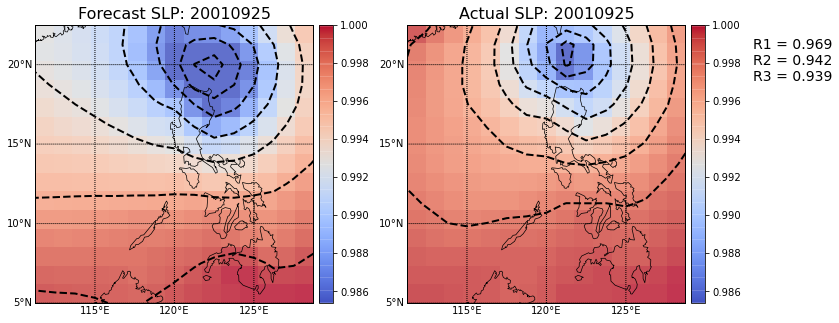

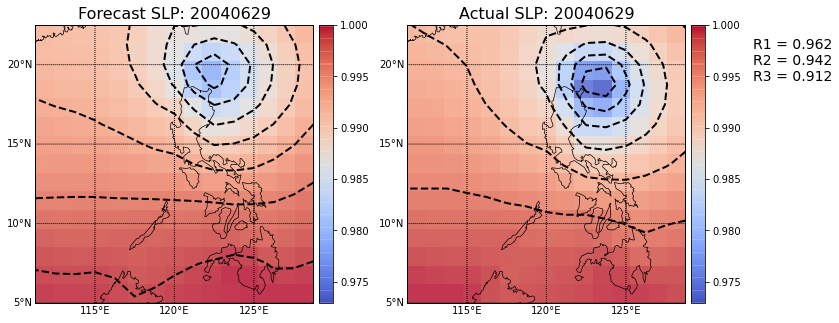

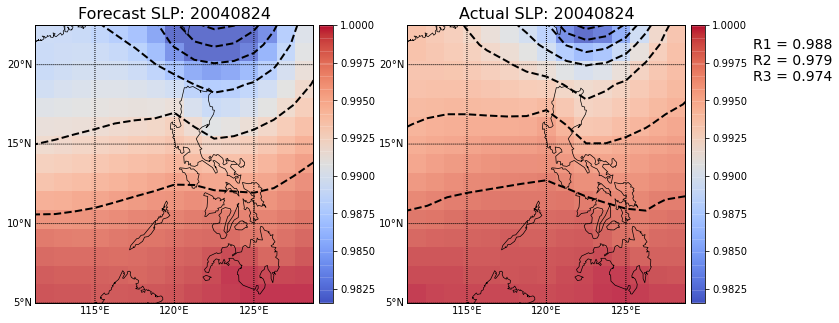

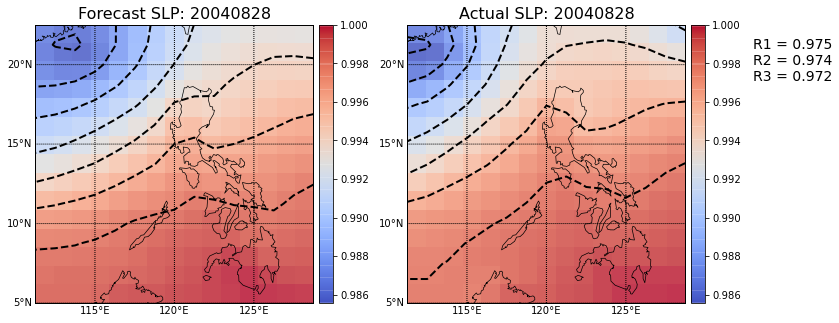

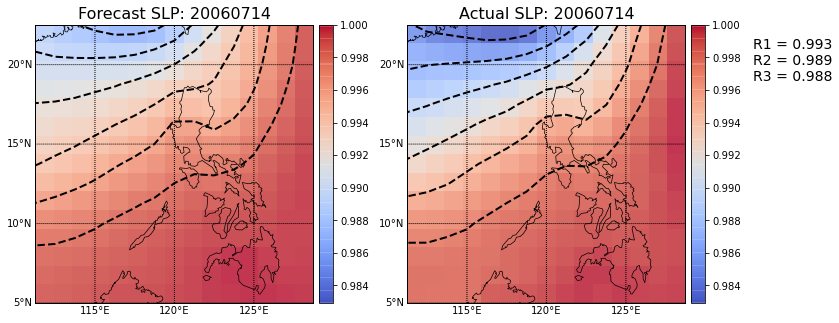

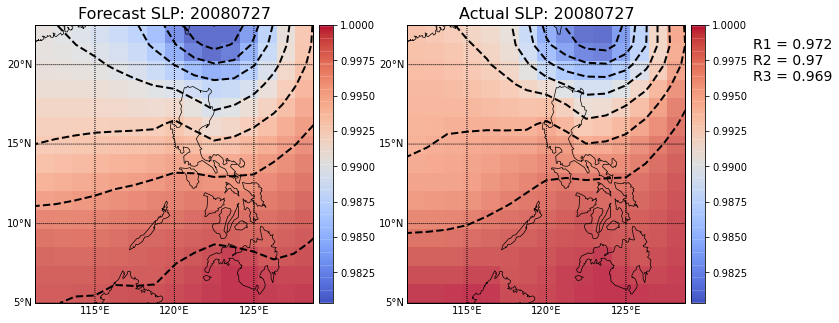

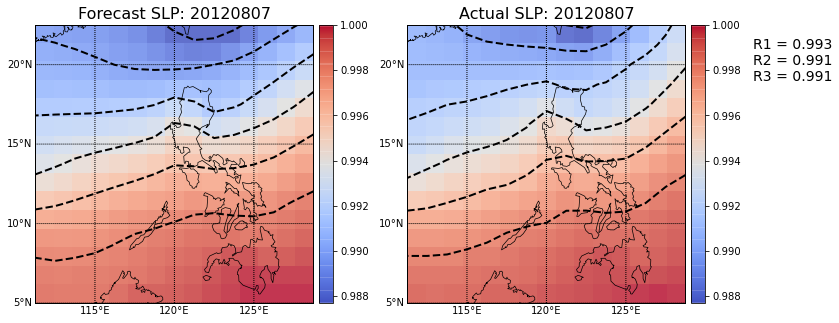

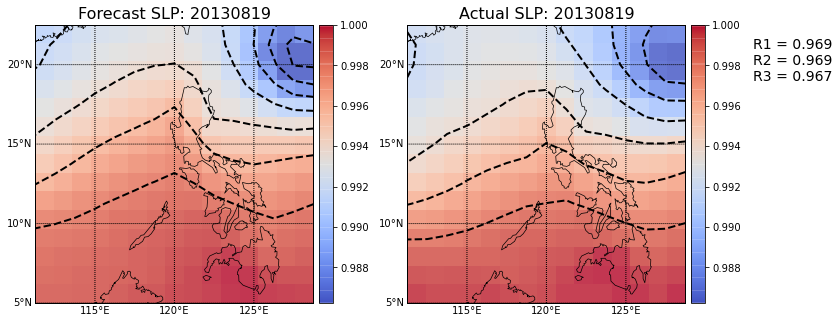

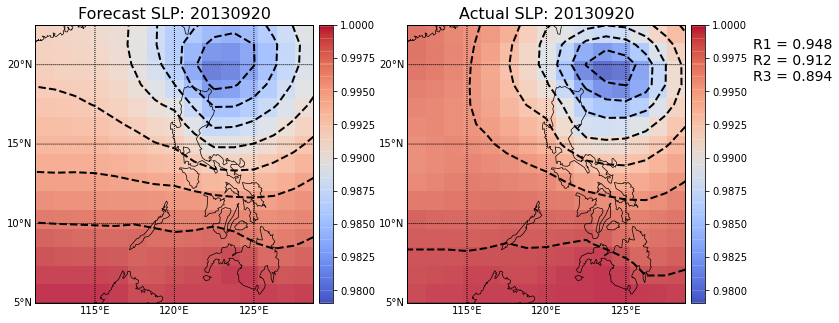

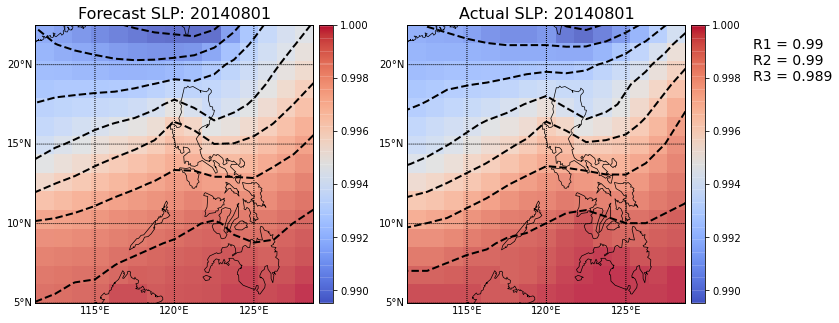

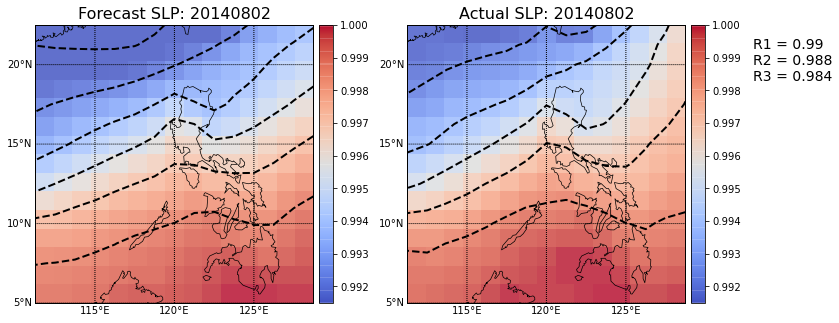

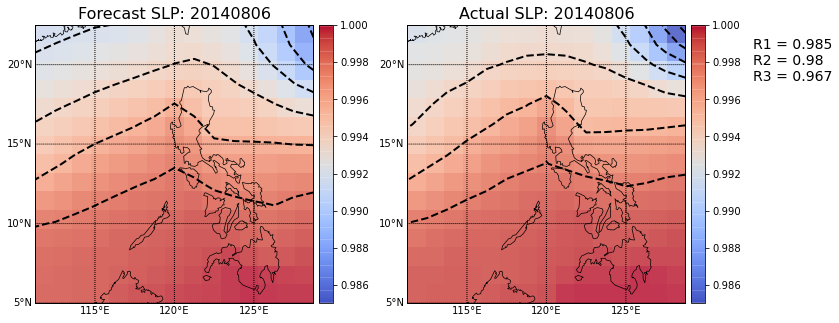

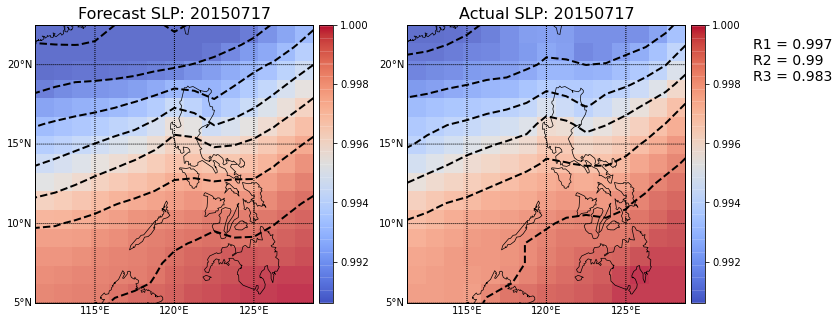

In [36]:
for j in range(len(match_ind)):
    #get actual SLP
    actual_slp = np.flip(test_slp[:,:,j],axis=0)
    actual_slp = actual_slp/np.max(actual_slp)

    #get composite SLP
    forecast_slp = np.flip(composite_slp_map[:,:,j],axis=0) 
    forecast_slp = forecast_slp/np.max(forecast_slp)

    fig = plt.figure(figsize=(12, 10))

    #show composite SLP map
    fig.add_subplot(1, 2, 1)

    #draw basemap
    m = Basemap(projection='cyl',llcrnrlon=111.25,urcrnrlon=128.75,llcrnrlat=5,urcrnrlat=22.5,resolution='l')
    m.drawcoastlines(linewidth=0.7)
    m.drawmapboundary()
    
    #create isobars
    X, Y = np.meshgrid(slp_longitude, slp_latitude)
    contours = plt.contour(X, Y, forecast_slp,colors='black',linestyles='dashed',linewidths=2)

    composite_slp_imshow = m.imshow(forecast_slp,cmap='coolwarm',alpha=0.8,zorder=1,\
                                   vmin=np.min(actual_slp),vmax=np.max(actual_slp))
    plt.title('Forecast SLP: '+test_days[j],fontsize=16)

    #draw latitudes and longitudes
    parallels = np.arange(5,36,5)
    m.drawparallels(parallels,labels=[True,False,True,False])
    meridians = np.arange(100,141,5)
    m.drawmeridians(meridians,labels=[True,False,False,True])

    m.colorbar(composite_slp_imshow,'right',shrink=0.5)

    #show actual SLP map
    fig.add_subplot(1, 2, 2)

    #draw basemap
    m = Basemap(projection='cyl',llcrnrlon=111.25,urcrnrlon=128.75,llcrnrlat=5,urcrnrlat=22.5,resolution='l')
    m.drawcoastlines(linewidth=0.7)
    m.drawmapboundary()

    #create isobars
    X, Y = np.meshgrid(slp_longitude, slp_latitude)
    contours = plt.contour(X, Y, actual_slp,colors='black',linestyles='dashed',linewidths=2)
    
    actual_slp_imshow = m.imshow(actual_slp,cmap='coolwarm',alpha=0.8,zorder=1)
    plt.title('Actual SLP: '+test_days[j],fontsize=16)

    #draw latitudes and longitudes
    parallels = np.arange(5,36,5)
    m.drawparallels(parallels,labels=[True,False,True,False])
    meridians = np.arange(100,141,5)
    m.drawmeridians(meridians,labels=[True,False,False,True])

    m.colorbar(actual_slp_imshow,'right',shrink=0.5)
    
    for p in range(N):
        plt.text(133,21-p,'R'+str(p+1)+' = '+str(np.round(slp_corr[j,-(p+1)],3)),fontsize=14)
    
    plt.subplots_adjust(wspace=0.25)
    
#     plt.savefig('../Sample Forecast/slp_corr'+str(test_days[j])+'.png',dpi=300,bbox_inches='tight')

    plt.show()

## Composite SLP plots for manuscript

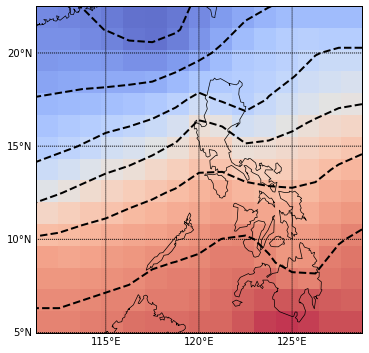

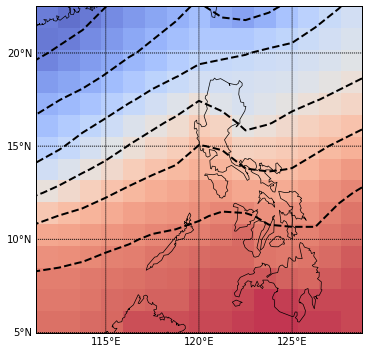

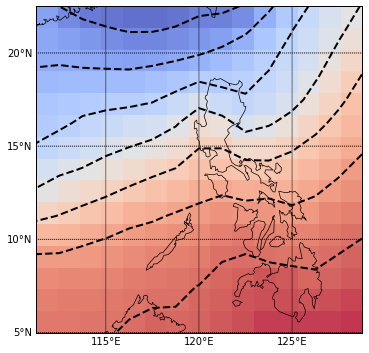

In [15]:
for j in range(3): 
   #get actual SLP
    actual_slp = np.flip(analog_slp[:,:,j],axis=0)
    actual_slp = actual_slp/np.max(actual_slp)

    fig = plt.figure(figsize=(8, 6))

   #draw basemap
    m = Basemap(projection='cyl',llcrnrlon=111.25,urcrnrlon=128.75,llcrnrlat=5,urcrnrlat=22.5,resolution='l')
    m.drawcoastlines(linewidth=0.7)
    m.drawmapboundary()
    
    #create isobars
    X, Y = np.meshgrid(slp_longitude, slp_latitude)
    contours = plt.contour(X, Y, actual_slp,colors='black',linestyles='dashed',linewidths=2)

    composite_slp_imshow = m.imshow(actual_slp,cmap='coolwarm',alpha=0.8,zorder=1)
#     plt.title('Forecast SLP: '+test_days[j],fontsize=16)

    #draw latitudes and longitudes
    parallels = np.arange(5,36,5)
    m.drawparallels(parallels,labels=[True,False,True,False])
    meridians = np.arange(100,141,5)
    m.drawmeridians(meridians,labels=[True,False,False,True])

#     m.colorbar(composite_slp_imshow,'right',shrink=0.5)
    
#     for p in range(N):
#         plt.text(132,21-p,'R'+str(p+1)+' = '+str(np.round(slp_corr[j,-(p+1)],3)),fontsize=14)
    
    plt.savefig('../../../MS Thesis/Thesis Manuscript v4/figures/RnD/Strong Habagat/actualslp_'+\
                str(dates[j])+'.png',dpi=300,bbox_inches='tight')
    plt.show()

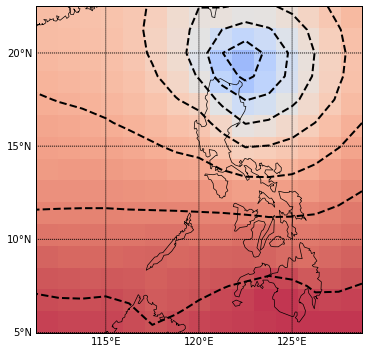

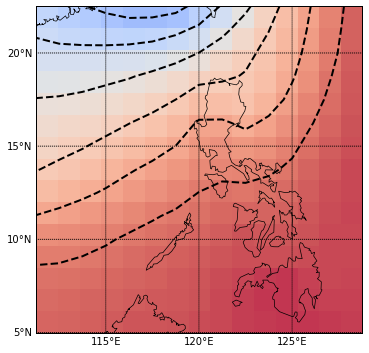

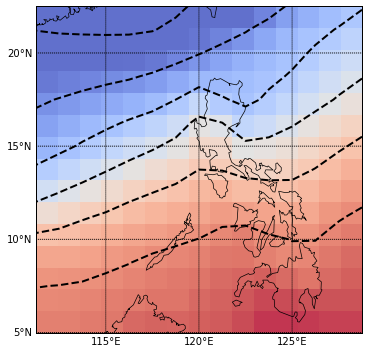

In [11]:
for j in [1,4,10]: 
   #get actual SLP
    actual_slp = np.flip(test_slp[:,:,j],axis=0)
    actual_slp = actual_slp/np.max(actual_slp)

    #get composite SLP
    forecast_slp = np.flip(composite_slp_map[:,:,j],axis=0) 
    forecast_slp = forecast_slp/np.max(forecast_slp)

    fig = plt.figure(figsize=(8, 6))

   #draw basemap
    m = Basemap(projection='cyl',llcrnrlon=111.25,urcrnrlon=128.75,llcrnrlat=5,urcrnrlat=22.5,resolution='l')
    m.drawcoastlines(linewidth=0.7)
    m.drawmapboundary()
    
    #create isobars
    X, Y = np.meshgrid(slp_longitude, slp_latitude)
    contours = plt.contour(X, Y, forecast_slp,colors='black',linestyles='dashed',linewidths=2)

    composite_slp_imshow = m.imshow(forecast_slp,cmap='coolwarm',alpha=0.8,zorder=1,\
                                   vmin=np.min(actual_slp),vmax=np.max(actual_slp))
#     plt.title('Forecast SLP: '+test_days[j],fontsize=16)

    #draw latitudes and longitudes
    parallels = np.arange(5,36,5)
    m.drawparallels(parallels,labels=[True,False,True,False])
    meridians = np.arange(100,141,5)
    m.drawmeridians(meridians,labels=[True,False,False,True])

#     m.colorbar(composite_slp_imshow,'right',shrink=0.5)
    
#     for p in range(N):
#         plt.text(132,21-p,'R'+str(p+1)+' = '+str(np.round(slp_corr[j,-(p+1)],3)),fontsize=14)
    
    plt.savefig('../../../MS Thesis/Thesis Manuscript v4/figures/RnD/Strong Habagat/dircorrslp_'+\
                str(test_days[j])+'.png',dpi=300,bbox_inches='tight')
#     plt.savefig('../Sample Forecast/dircorrslp_'+str(test_days[j])+'.png',dpi=300,bbox_inches='tight')
    plt.show()

### Load indices of longitude and latitude of PAGASA stations in rain grid

In [12]:
station_lon = np.load('../Small Domain/station_lon_index.npy')
station_lat = np.load('../Small Domain/station_lat_index.npy')

### Load observed rainfall per station 

In [13]:
luzon_ind = np.load('../Small Domain/luzon_index.npy')
obs_rain = pd.read_csv('../obs_strong_habagat.csv',header=None).values[:,luzon_ind]

test_obs_rain = obs_rain[test_index]
train_obs_rain = obs_rain[train_index]

## Compare forecast and actual rainfall, and calculate contingency table

In [14]:
#heavy rain threshold
threshold_rain = [0.5,30]

#neighbour size of forecast
N = [1,2]

#create array containing contingency table per day for different threshold and neighbour size
cont_table = np.zeros((test_obs_rain.shape[0],5,len(threshold_rain),len(N)))

for t in range(len(threshold_rain)):
    for n in range(len(N)):
        for a in range(test_obs_rain.shape[0]):
            #get composite rain
            composite_rain = composite_rain_map[:,:,a] 

            for b in range(test_obs_rain.shape[1]):
                lat_index = station_lat[b]
                lon_index = station_lon[b]

                #get actual station rain
                actual_station_rain = test_obs_rain[a][b]

                #check if observed rain is missing
                if np.isnan(actual_station_rain):
                    cont_table[a,4,t] += 1

                else:
                    #get composite station rain within grid
                    composite_station_rain = composite_rain[lat_index-N[n]:lat_index+(N[n]+1), \
                                                            lon_index-N[n]:lon_index+(N[n]+1)]

                    #compare actual rain to grid of forecast
                    diff = np.abs(actual_station_rain-composite_station_rain).argmin()
                    forecast_station_rain = composite_station_rain.flatten()[diff]

                    #count hits per day
                    if actual_station_rain >= threshold_rain[t] and forecast_station_rain >= threshold_rain[t]:
                        cont_table[a,0,t,n] += 1

                    #count false alarms per day
                    elif actual_station_rain < threshold_rain[t] and forecast_station_rain >= threshold_rain[t]:
                        cont_table[a,1,t,n] += 1

                    #count misses per day
                    elif actual_station_rain >= threshold_rain[t] and forecast_station_rain < threshold_rain[t]:
                        cont_table[a,2,t,n] += 1

                    #count correct negatives per day
                    else:
                        cont_table[a,3,t,n] += 1

## Calculate contingency scores

In [15]:
# 0 = hits
# 1 = false alarms
# 2 = misses
# 3 = correct negatives

#calculate threat score
ts = cont_table[:,0,:,:]/(cont_table[:,0,:,:]+cont_table[:,1,:,:]+cont_table[:,2,:,:])

#calculate bias
bias = (cont_table[:,0,:,:]+cont_table[:,1,:,:])/(cont_table[:,0,:,:]+cont_table[:,2,:,:])

#calculate probability of detection
pod = cont_table[:,0,:,:]/(cont_table[:,0,:,:]+cont_table[:,2,:,:])

#calculate false alarm ratio
far = cont_table[:,1,:,:]/(cont_table[:,0,:,:]+cont_table[:,1,:,:])

<ipython-input-15-380e9cbdd595>:16: RuntimeWarning: invalid value encountered in true_divide
  far = cont_table[:,1,:,:]/(cont_table[:,0,:,:]+cont_table[:,1,:,:])


In [16]:
np.nanmean(ts,axis=0)

array([[0.70823585, 0.72249333],
       [0.40894618, 0.53583639]])

## Rainfall forecast plots for manuscript

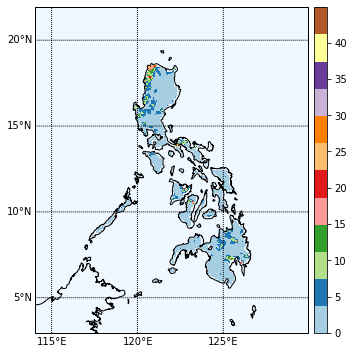

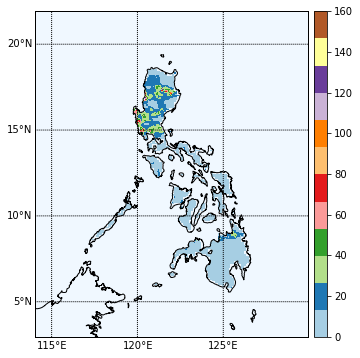

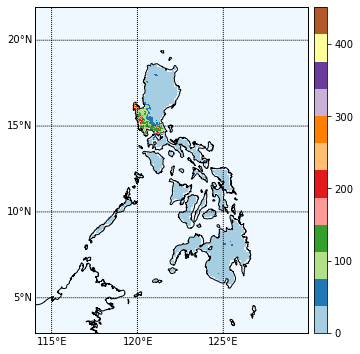

In [24]:
#get latitudes
rain_latitude = np.ma.getdata(daily_rain2['lat'])
#get longitudes
rain_longitude = np.ma.getdata(daily_rain2['lon'])

lon, lat = np.meshgrid(rain_longitude,rain_latitude)

for j in range(3): #range(composite_rain_map.shape[2]):
    #get masked composite rain
    composite_rain = analog_rain[:,:,j] 
    masked_composite = maskoceans(lon,lat,composite_rain,resolution='i')
    masked_composite.mask[:41,:52] = True

    fig = plt.figure(figsize=(8, 6))

    #draw basemap
    m = Basemap(projection='cyl',llcrnrlon=114.05,urcrnrlon=129.95,llcrnrlat=2.95,urcrnrlat=21.95,resolution='i')
    m.drawcoastlines(linewidth=1)
    m.drawmapboundary(fill_color='aliceblue')

    composite_rain_imshow = m.imshow(masked_composite,cmap='Paired',zorder=1)
#     plt.title('Rainfall Forecast: '+test_days[j],fontsize=16)

    #draw latitudes and longitudes
    parallels = np.arange(5,21,5)
    m.drawparallels(parallels,labels=[True,False,True,False])
    meridians = np.arange(115,141,5)
    m.drawmeridians(meridians,labels=[True,False,False,True])

    m.colorbar(composite_rain_imshow,'right',shrink=0.5)

    plt.savefig('../../../MS Thesis/Thesis Manuscript v4/figures/RnD/Strong Habagat/actualrain_'+str(dates[j])+\
                '.png',dpi=300,bbox_inches='tight')
    plt.show()

NameError: name 'threshold_rain' is not defined

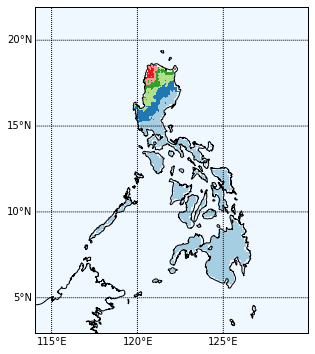

In [19]:
#get latitudes
rain_latitude = np.ma.getdata(daily_rain2['lat'])
#get longitudes
rain_longitude = np.ma.getdata(daily_rain2['lon'])

lon, lat = np.meshgrid(rain_longitude,rain_latitude)

for j in [1,4,10]: #range(composite_rain_map.shape[2]):
    #get masked actual rain
    actual_rain = actual_rain_map[:,:,j]
    masked_actual = maskoceans(lon,lat,actual_rain,resolution='i')
    masked_actual.mask[:41,:52] = True

    #get masked composite rain
    composite_rain = composite_rain_map[:,:,j] 
    masked_composite = maskoceans(lon,lat,composite_rain,resolution='i')
    masked_composite.mask[:41,:52] = True

    fig = plt.figure(figsize=(8, 6))

    #draw basemap
    m = Basemap(projection='cyl',llcrnrlon=114.05,urcrnrlon=129.95,llcrnrlat=2.95,urcrnrlat=21.95,resolution='i')
    m.drawcoastlines(linewidth=1)
    m.drawmapboundary(fill_color='aliceblue')

    composite_rain_imshow = m.imshow(masked_composite,cmap='Paired',zorder=1,\
                                     vmin=np.min(masked_actual),vmax=np.max(masked_actual))
#     plt.title('Rainfall Forecast: '+test_days[j],fontsize=16)

    #draw latitudes and longitudes
    parallels = np.arange(5,21,5)
    m.drawparallels(parallels,labels=[True,False,True,False])
    meridians = np.arange(115,141,5)
    m.drawmeridians(meridians,labels=[True,False,False,True])

#     m.colorbar(composite_rain_imshow,'right',shrink=0.5)
    
  #display contingency scores at 50mm threshold, N=1
    plt.text(130.5,22,'HRT = '+str(threshold_rain[0])+' mm, N = '+str(N[0]*2 + 1),fontsize=11)
    plt.text(132,21,'TS = '+str(np.round(ts[j,0,0],3)),fontsize=10)
    plt.text(132,20,'BIAS = '+str(np.round(bias[j,0,0],3)),fontsize=10)
    plt.text(132,19,'POD = '+str(np.round(pod[j,0,0],3)),fontsize=10)
    plt.text(132,18,'FAR = '+str(np.round(far[j,0,0],3)),fontsize=10)

    #display contingency scores at 75mm threshold, N=1
    plt.text(130.5,17,'HRT = '+str(threshold_rain[1])+' mm, N = '+str(N[0]*2 + 1),fontsize=11)
    plt.text(132,16,'TS = '+str(np.round(ts[j,1,0],3)),fontsize=10)
    plt.text(132,15,'BIAS = '+str(np.round(bias[j,1,0],3)),fontsize=10)
    plt.text(132,14,'POD = '+str(np.round(pod[j,1,0],3)),fontsize=10)
    plt.text(132,13,'FAR = '+str(np.round(far[j,1,0],3)),fontsize=10)

    #display contingency scores at 50mm threshold, N=2
    plt.text(130.5,12,'HRT = '+str(threshold_rain[0])+' mm, N = '+str(N[1]*2 + 1),fontsize=11)
    plt.text(132,11,'TS = '+str(np.round(ts[j,1,1],3)),fontsize=10)
    plt.text(132,10,'BIAS = '+str(np.round(bias[j,1,1],3)),fontsize=10)
    plt.text(132,9,'POD = '+str(np.round(pod[j,1,1],3)),fontsize=10)
    plt.text(132,8,'FAR = '+str(np.round(far[j,1,1],3)),fontsize=10)

    #display contingency scores at 75mm threshold, N=2
    plt.text(130.5,7,'HRT = '+str(threshold_rain[1])+' mm, N = '+str(N[1]*2 + 1),fontsize=11)
    plt.text(132,6,'TS = '+str(np.round(ts[j,1,1],3)),fontsize=10)
    plt.text(132,5,'BIAS = '+str(np.round(bias[j,1,1],3)),fontsize=10)
    plt.text(132,4,'POD = '+str(np.round(pod[j,1,1],3)),fontsize=10)
    plt.text(132,3,'FAR = '+str(np.round(far[j,1,1],3)),fontsize=10)

#     plt.savefig('../../../MS Thesis/Thesis Manuscript v4/figures/RnD/Strong Habagat/dircorr_'+str(test_days[j])+\
#                 '.png',dpi=300,bbox_inches='tight')
    
#     plt.savefig('../Sample Forecast/dircorr_'+str(test_days[j])+'.png',dpi=300,bbox_inches='tight')
    plt.show()

## Compare test and matching rainfall

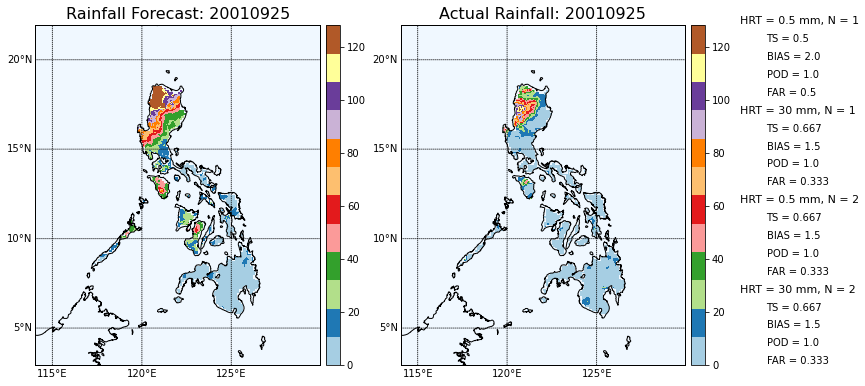

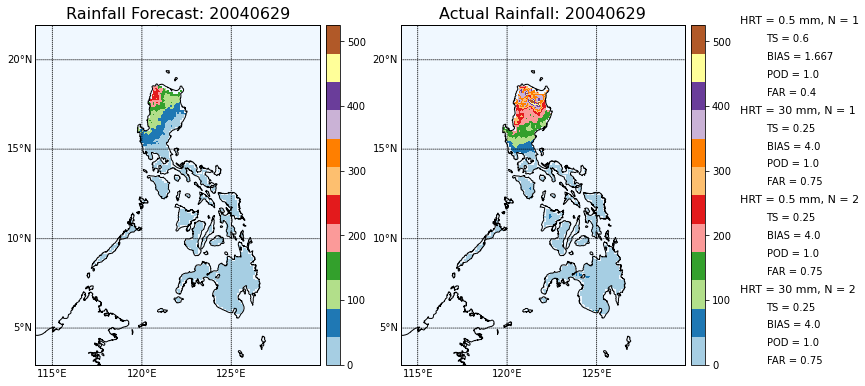

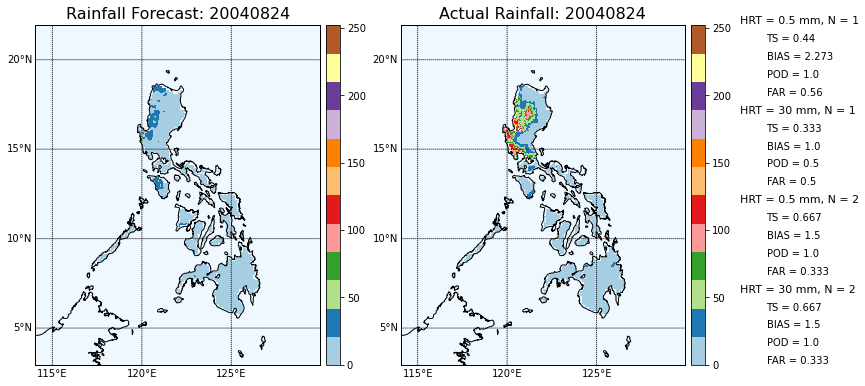

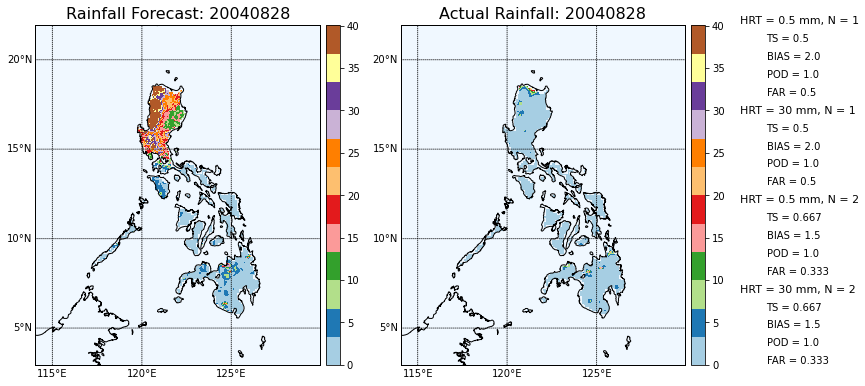

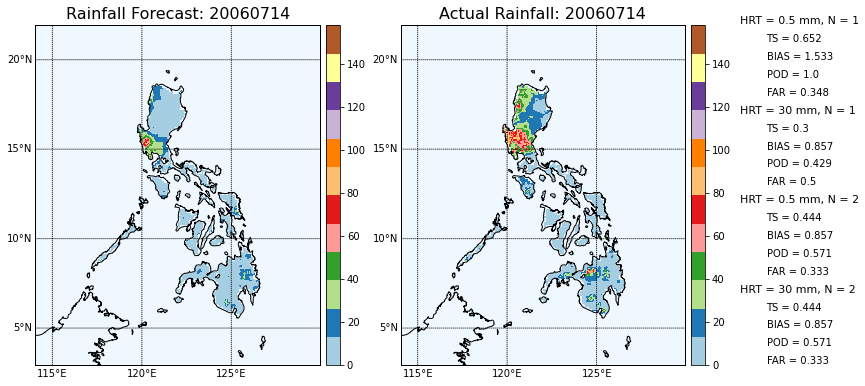

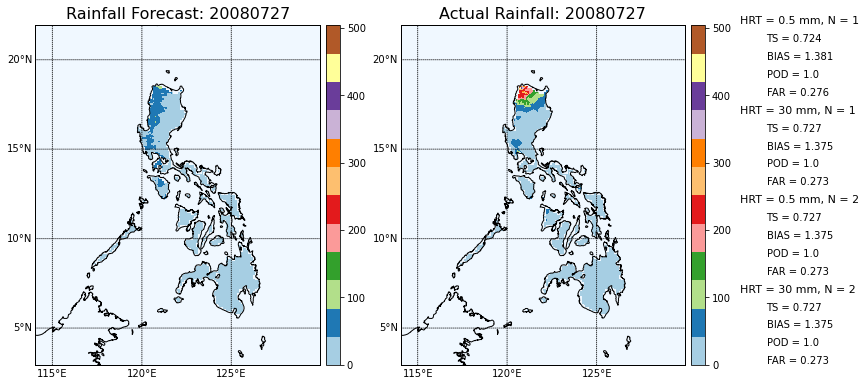

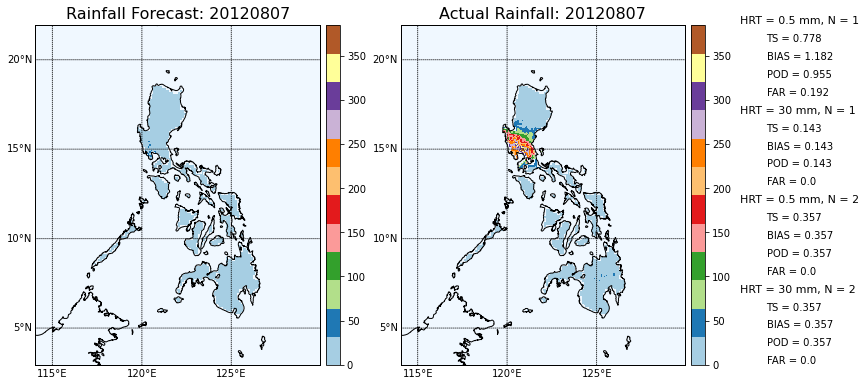

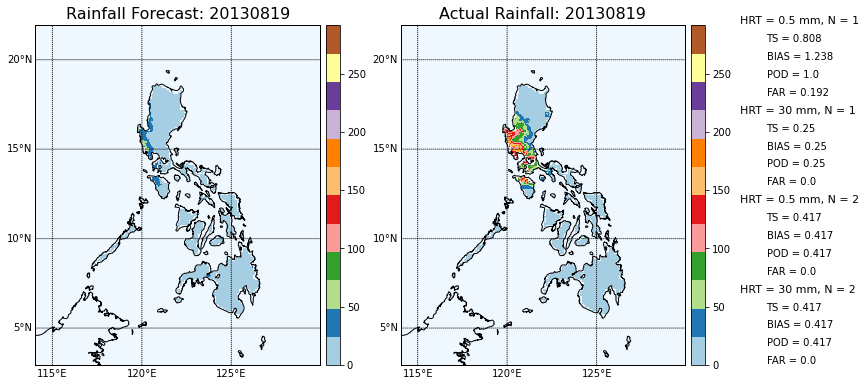

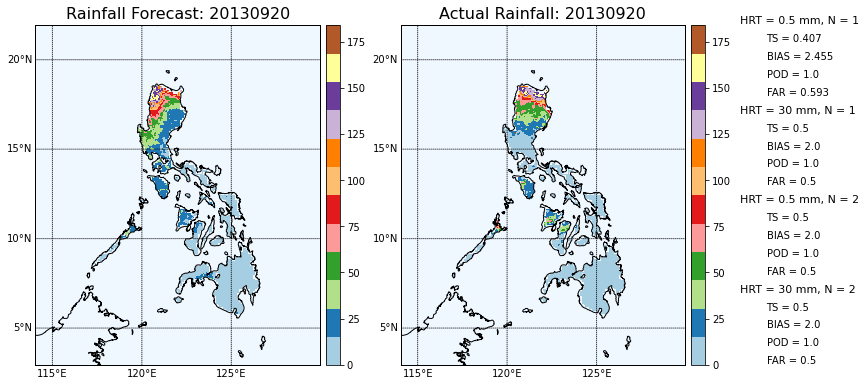

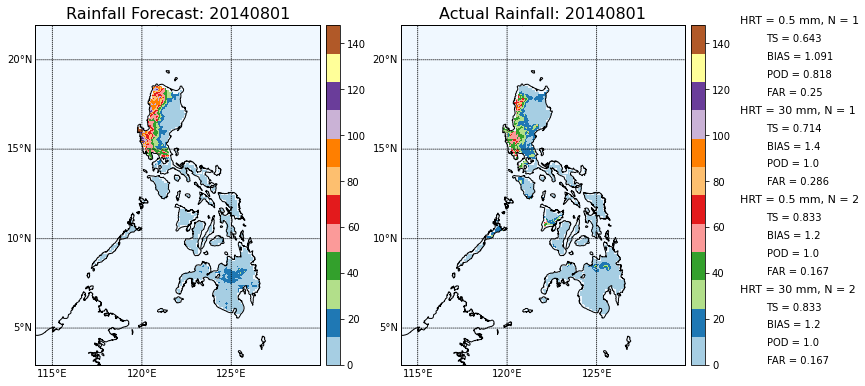

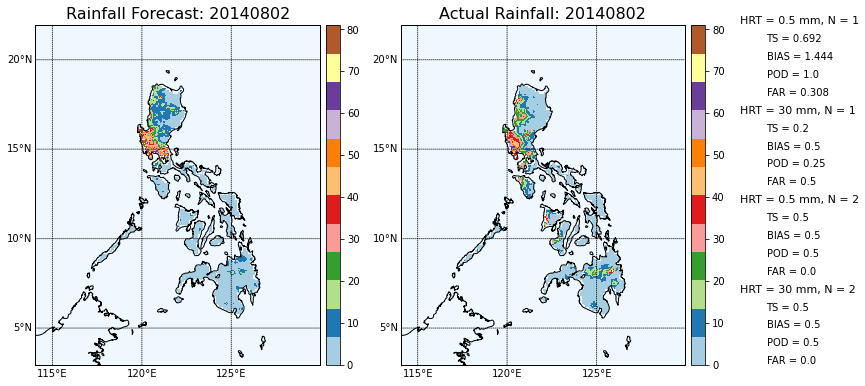

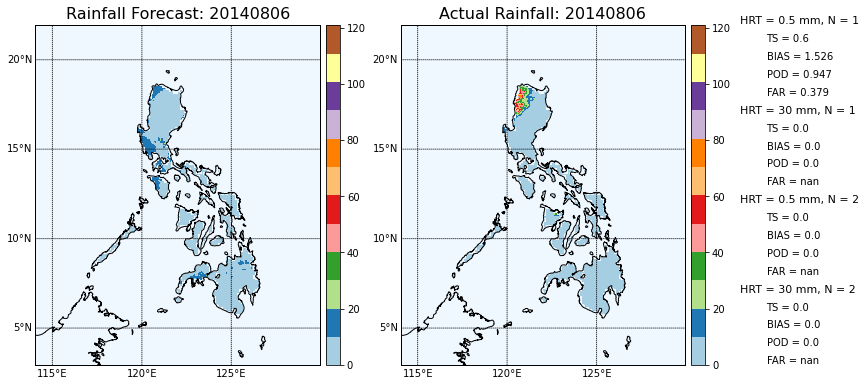

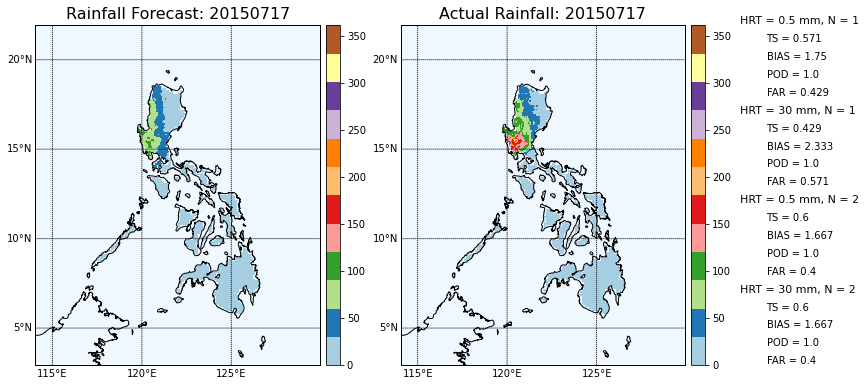

In [15]:
#get latitudes
rain_latitude = np.ma.getdata(daily_rain2['lat'])
#get longitudes
rain_longitude = np.ma.getdata(daily_rain2['lon'])

lon, lat = np.meshgrid(rain_longitude,rain_latitude)

for j in range(len(match_ind)):    
    #get masked actual rain
    actual_rain = actual_rain_map[:,:,j]
    masked_actual = maskoceans(lon,lat,actual_rain,resolution='i')
    masked_actual.mask[:41,:52] = True

    #get masked composite rain
    composite_rain = composite_rain_map[:,:,j] 
    masked_composite = maskoceans(lon,lat,composite_rain,resolution='i')
    masked_composite.mask[:41,:52] = True

    fig = plt.figure(figsize=(12, 10))

    #show archetype rain map
    fig.add_subplot(1, 2, 1)

    #draw basemap
    m = Basemap(projection='cyl',llcrnrlon=114.05,urcrnrlon=129.95,llcrnrlat=2.95,urcrnrlat=21.95,resolution='i')
    m.drawcoastlines(linewidth=1)
    m.drawmapboundary(fill_color='aliceblue')

    composite_rain_imshow = m.imshow(masked_composite,cmap='Paired',zorder=1,\
                                     vmin=np.min(masked_actual),vmax=np.max(masked_actual))
    plt.title('Rainfall Forecast: '+test_days[j],fontsize=16)

    #draw latitudes and longitudes
    parallels = np.arange(5,21,5)
    m.drawparallels(parallels,labels=[True,False,True,False])
    meridians = np.arange(115,141,5)
    m.drawmeridians(meridians,labels=[True,False,False,True])

    m.colorbar(composite_rain_imshow,'right',shrink=0.5)

    #show actual rain map
    fig.add_subplot(1, 2, 2)

    #draw basemap
    m = Basemap(projection='cyl',llcrnrlon=114.05,urcrnrlon=129.95,llcrnrlat=2.95,urcrnrlat=21.95,resolution='i')
    m.drawcoastlines(linewidth=1)
    m.drawmapboundary(fill_color='aliceblue')

    actual_rain_imshow = m.imshow(masked_actual,cmap='Paired',zorder=1) 
    plt.title('Actual Rainfall: '+test_days[j],fontsize=16)

    #draw latitudes and longitudes
    parallels = np.arange(5,21,5)
    m.drawparallels(parallels,labels=[True,False,True,False])
    meridians = np.arange(115,141,5)
    m.drawmeridians(meridians,labels=[True,False,False,True])

    m.colorbar(actual_rain_imshow,'right',shrink=0.5)
    
     #display contingency scores at 50mm threshold, N=1
    plt.text(133,22,'HRT = '+str(threshold_rain[0])+' mm, N = '+str(N[0]),fontsize=11)
    plt.text(134.5,21,'TS = '+str(np.round(ts[j,0,0],3)),fontsize=10)
    plt.text(134.5,20,'BIAS = '+str(np.round(bias[j,0,0],3)),fontsize=10)
    plt.text(134.5,19,'POD = '+str(np.round(pod[j,0,0],3)),fontsize=10)
    plt.text(134.5,18,'FAR = '+str(np.round(far[j,0,0],3)),fontsize=10)
    
    #display contingency scores at 75mm threshold, N=1
    plt.text(133,17,'HRT = '+str(threshold_rain[1])+' mm, N = '+str(N[0]),fontsize=11)
    plt.text(134.5,16,'TS = '+str(np.round(ts[j,1,0],3)),fontsize=10)
    plt.text(134.5,15,'BIAS = '+str(np.round(bias[j,1,0],3)),fontsize=10)
    plt.text(134.5,14,'POD = '+str(np.round(pod[j,1,0],3)),fontsize=10)
    plt.text(134.5,13,'FAR = '+str(np.round(far[j,1,0],3)),fontsize=10)
    
    #display contingency scores at 50mm threshold, N=2
    plt.text(133,12,'HRT = '+str(threshold_rain[0])+' mm, N = '+str(N[1]),fontsize=11)
    plt.text(134.5,11,'TS = '+str(np.round(ts[j,1,1],3)),fontsize=10)
    plt.text(134.5,10,'BIAS = '+str(np.round(bias[j,1,1],3)),fontsize=10)
    plt.text(134.5,9,'POD = '+str(np.round(pod[j,1,1],3)),fontsize=10)
    plt.text(134.5,8,'FAR = '+str(np.round(far[j,1,1],3)),fontsize=10)
    
    #display contingency scores at 75mm threshold, N=2
    plt.text(133,7,'HRT = '+str(threshold_rain[1])+' mm, N = '+str(N[1]),fontsize=11)
    plt.text(134.5,6,'TS = '+str(np.round(ts[j,1,1],3)),fontsize=10)
    plt.text(134.5,5,'BIAS = '+str(np.round(bias[j,1,1],3)),fontsize=10)
    plt.text(134.5,4,'POD = '+str(np.round(pod[j,1,1],3)),fontsize=10)
    plt.text(134.5,3,'FAR = '+str(np.round(far[j,1,1],3)),fontsize=10)
    
    plt.savefig('../Sample Forecast/correlation'+str(test_days[j])+'.png',dpi=300,bbox_inches='tight')
    
    plt.show()